# task6：使用Transformer进行情感分析

在本notebook中，我们将使用在 [Attention is all you need](https://arxiv.org/abs/1706.03762) 论文中首次引入的Transformer模型。 具体来说，我们将使用 [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) 论文中的 BERT模型。

Transformer 模型比本教程中涵盖的其他模型都要大得多。 因此，我们将使用 [transformers library](https://github.com/huggingface/transformers) 来获取预训练的Transformer并将它们用作我们的embedding层。 我们将固定（而不训练）transformer，只训练从transformer产生的表示中学习的模型的其余部分。 在这种情况下，我们将使用双向GRU继续提取从Bert embedding后的特征。最后在fc层上输出最终的结果。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 6.1 数据准备

首先，像往常一样，我们导入库，然后设置随机种子

In [ ]:
!nvidia-smi

In [ ]:
# pip install torch==1.8.0+cu102 torchvision==0.9.0+cu102 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
pip install torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.5 LTS
Release:	20.04
Codename:	focal


In [ ]:
import os
os.chdir('/content/drive/My Drive')

In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

True
cuda


Transformer 已经用特定的词汇进行了训练，这意味着我们需要使用完全相同的词汇进行训练，并以与 Transformer 最初训练时相同的方式标记我们的数据。

幸运的是，transformers 库为每个提供的transformer 模型都有分词器。 在这种情况下，我们使用忽略大小写的 BERT 模型（即每个单词都会小写）。 我们通过加载预训练的“bert-base-uncased”标记器来实现这一点。

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

`tokenizer` 有一个 `vocab` 属性，它包含我们将使用的实际词汇。 我们可以通过检查其长度来检查其中有多少单词。

In [ ]:
len(tokenizer.vocab)

30522

使用`tokenizer.tokenize`方法对字符串进行分词，并统一大小写。

In [ ]:
tokens = tokenizer.tokenize('Hello WORLD how ARE yoU?')

print(tokens)

['hello', 'world', 'how', 'are', 'you', '?']


我们可以使用我们的词汇表使用 `tokenizer.convert_tokens_to_ids` 来数字化标记。下面的tokens是我们之前上面进行了分词和统一大小写之后的list。

In [ ]:
indexes = tokenizer.convert_tokens_to_ids(tokens)

print(indexes)

[7592, 2088, 2129, 2024, 2017, 1029]


Transformer还接受了特殊tokens的训练，以标记句子的开头和结尾， [详细信息](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel)。 就像我们标准化padding和未知的token一样，我们也可以从`tokenizer`中获取这些。

**注意**：`tokenizer` 确实有序列开始和序列结束属性（`bos_token` 和 `eos_token`），但我们没有对此进行设置，并且不适用于我们本次训练的transformer。

In [ ]:

init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


我们可以通过反转词汇表来获得特殊tokens的索引

In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


或者通过tokenizer的方法直接获取它们

In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


我们需要处理的另一件事是模型是在具有定义的最大长度的序列上训练的——它不知道如何处理比训练更长的序列。 我们可以通过检查我们想要使用的转换器版本的 `max_model_input_sizes` 来获得这些输入大小的最大长度。

In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


之前我们使用了 `spaCy` 标记器来标记我们的示例。 然而，我们现在需要定义一个函数，我们将把它传递给我们的 `TEXT` 字段，它将为我们处理所有的标记化。 它还会将令牌的数量减少到最大长度。 请注意，我们的最大长度比实际最大长度小 2。 这是因为我们需要向每个序列附加两个标记，一个在开头，一个在结尾。

In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

现在我们开始定义我们的字段,transformer期望将batch维度放在第一维上，所以我们设置了 `batch_first = True`。 现在我们已经有了文本的词汇数据，由transformer提供，我们设置 `use_vocab = False` 来告诉 torchtext 已经不需要切分数据了。 我们将 `tokenize_and_cut` 函数作为标记器传递。 `preprocessing` 参数是一个函数，这是我们将token转换为其索引的地方。 最后，我们定义特殊的token——注意我们将它们定义为它们的索引值而不是它们的字符串值，即“100”而不是“[UNK]”这是因为序列已经被转换为索引。

我们像以前一样定义标签字段。

In [ ]:
from torchtext.legacy import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

加载数据，拆分成训练集和验证集

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


随便看一个例子，看下具体效果如何,输出其中一个句子的one-hot向量。

In [ ]:
print(vars(train_data.examples[6]))

{'text': [2178, 3127, 1999, 1996, 7552, 3160, 1010, 3649, 3047, 2000, 11463, 8379, 1005, 1055, 3168, 1997, 8562, 1029, 2009, 4627, 2041, 19957, 2438, 1010, 2007, 11463, 2004, 8398, 1011, 2066, 9587, 24848, 22547, 10053, 1006, 1000, 2017, 2064, 2655, 2033, 2643, 1000, 1007, 1010, 2040, 13385, 1037, 6655, 2008, 2002, 2064, 1005, 1056, 2444, 2006, 1996, 4534, 2005, 2382, 2420, 1012, 2021, 1996, 2617, 1996, 3185, 4978, 1996, 4534, 1010, 2009, 4332, 2046, 1037, 4130, 2891, 1011, 14887, 6752, 1010, 2007, 8138, 1000, 6057, 1000, 9017, 6970, 24455, 1006, 11463, 5927, 1037, 2304, 4845, 3338, 1011, 5613, 2005, 2769, 1998, 5363, 2000, 2079, 1037, 19698, 10131, 1011, 1998, 1011, 3358, 1010, 9805, 2243, 1010, 9805, 2243, 1007, 1012, 8886, 5754, 6031, 2003, 2498, 2460, 1997, 13842, 1012, 1996, 5409, 2112, 2003, 2023, 3185, 1005, 1055, 3315, 2193, 1010, 1999, 2029, 8379, 1998, 6031, 2079, 1037, 4333, 3153, 2000, 5624, 8716, 1005, 1055, 1000, 3733, 2000, 2293, 1012, 1000, 8379, 1005, 1055, 3315, 11968

我们可以使用 `convert_ids_to_tokens` 将这些索引转换回可读的tokens。

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[6])['text'])

print(tokens)

['another', 'chapter', 'in', 'the', 'ongoing', 'question', ',', 'whatever', 'happened', 'to', 'mel', 'brooks', "'", 's', 'sense', 'of', 'humor', '?', 'it', 'starts', 'out', 'nicely', 'enough', ',', 'with', 'mel', 'as', 'trump', '-', 'like', 'mo', '##gul', 'goddard', 'bolt', '(', '"', 'you', 'can', 'call', 'me', 'god', '"', ')', ',', 'who', 'accepts', 'a', 'bet', 'that', 'he', 'can', "'", 't', 'live', 'on', 'the', 'streets', 'for', '30', 'days', '.', 'but', 'the', 'moment', 'the', 'movie', 'hits', 'the', 'streets', ',', 'it', 'turns', 'into', 'a', 'path', '##os', '-', 'laden', 'mess', ',', 'with', 'occasional', '"', 'funny', '"', 'bits', 'inter', '##jected', '(', 'mel', 'sees', 'a', 'black', 'kid', 'break', '-', 'dancing', 'for', 'money', 'and', 'tries', 'to', 'do', 'a', 'vaudeville', 'buck', '-', 'and', '-', 'wing', ',', 'yu', '##k', ',', 'yu', '##k', ')', '.', 'leslie', 'ann', 'warren', 'is', 'nothing', 'short', 'of', 'wasted', '.', 'the', 'worst', 'part', 'is', 'this', 'movie', "'", 

尽管我们已经处理了文本的词汇表，当然也需要为标签构建词汇表。

In [ ]:
LABEL.build_vocab(train_data)

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


像之前一样，我们创建迭代器。根据以往经验，使用最大的batch size可以使transformer获得最好的效果，当然，你也可以尝试一下使用其他的batch size，如果你的显卡比较好的话。

In [ ]:
BATCH_SIZE = 128


train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device=device)

In [ ]:
!nvidia-smi

# 6.2 构建模型

接下来，我们导入预训练模型。

In [ ]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


接下来，我们将定义我们的实际模型。

我们将使用预训练的 Transformer 模型，而不是使用embedding层来获取文本的embedding。然后将这些embedding输入GRU以生成对输入句子情绪的预测。我们通过其 config 属性从transformer中获取嵌入维度大小（称为`hidden_size`）。其余的初始化是标准的。

在前向传递中，我们将transformer包装在一个`no_grad`中，以确保不会在模型的这部分计算梯度。transformer实际上返回整个序列的embedding以及 *pooled* 输出。 [Bert模型文档](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel) 指出，汇集的输出“通常不是输入语义内容的一个很好的总结，你通常更好对整个输入序列的隐藏状态序列进行平均或合并”，因此我们不会使用它。前向传递的其余部分是循环模型的标准实现，我们在最后的时间步长中获取隐藏状态，并将其传递给一个线性层以获得我们的预测。

In [ ]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

我们使用标准超参数创建模型的实例。

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

我们可以检查模型有多少参数，我们的标准型号有不到5M的参数，但这个模型有112M 幸运的是，而且这些参数中有 110M 来自transformer，我们不必再训练它们。

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,241,409 trainable parameters


为了固定参数（不需要训练它们），我们需要将它们的 `requires_grad` 属性设置为 `False`。 为此，我们只需遍历模型中的所有 `named_parameters`，如果它们是 `bert` 转换器模型的一部分，我们设置 `requires_grad = False`，如微调的话，需要将`requires_grad`设置为`True`

In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

我们现在可以看到我们的模型有不到3M的可训练参数，这使得它几乎可以与`FastText`模型相媲美。 然而，文本仍然必须通过transformer传播，这导致训练需要更长的时间。

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


我们可以仔细检查可训练参数的名称，确保它们有意义。 我们可以看到，它们都是 GRU（`rnn`）和线性层（`out`）的参数。

In [ ]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


## 6.3 训练模型

按照惯例，我们构建自己的模型评价标准(损失函数)，仍然是二分类

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

将模型和评价标准（损失函数）放在 GPU 上，如果你有GPU的话

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
torch.cuda.empty_cache()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for idx, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        if (idx+1) % 250 == 0:
          print("====", idx, "acc:", epoch_acc/idx, "loss:", epoch_loss/idx, "====")
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

最后，我们将训练我们的模型。 由于transformer的尺寸的原因，这比以前的任何型号都要长得多。 即使我们没有训练任何transformer的参数，我们仍然需要通过模型传递数据，这在标准 GPU 上需要花费大量时间。

In [ ]:
import matplotlib.pyplot as plt

Epoch: 01 | Epoch Time: 12m 54s
	Train Loss: 0.316 | Train Acc: 86.84%
	 Val. Loss: 0.229 |  Val. Acc: 90.83%
Epoch: 02 | Epoch Time: 12m 53s
	Train Loss: 0.258 | Train Acc: 89.56%
	 Val. Loss: 0.221 |  Val. Acc: 91.41%
Epoch: 03 | Epoch Time: 12m 53s
	Train Loss: 0.227 | Train Acc: 90.88%
	 Val. Loss: 0.247 |  Val. Acc: 90.26%


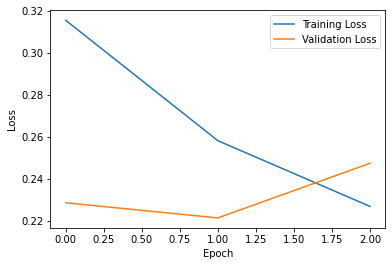

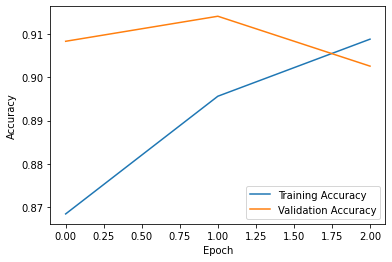

In [ ]:
N_EPOCHS = 3
train_loss_history=[]
valid_loss_history=[]
train_acc_history=[]
valid_acc_history=[]
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    # Save loss and accuracy history
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)
# Plot loss history
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

我们将加载为我们提供最佳验证集上损失值的参数，并在测试集上应用这些参数 - 并在测试集上达到了最优的结果。

In [ ]:
model.load_state_dict(torch.load('./tut6-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## 6.4 模型验证

然后我们将使用该模型来测试一些序列的情绪。 我们对输入序列进行标记，将其修剪到最大长度，将特殊token添加到任一侧，将其转换为张量，使用unsqueeze函数增加一维，然后将其传递给我们的模型。

In [ ]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    # return prediction.item()
    if prediction >= 0.75:
      print(prediction.item(),"This sentence represents a strong positive emotion.")
    elif 0.55 < prediction and prediction < 0.75:
      print(prediction.item(),"This sentence represents a weak postive emotion.")
    elif 0.45<= prediction and prediction <= 0.55:
      print(prediction.item(),"This sentence represents a neutral emotion.")
    elif 0.25 < prediction and prediction < 0.45:
      print(prediction.item(),"This sentence represents a weak negative emotion.")
    elif 0 < prediction and prediction <= 0.25:
      print(prediction.item(),"This sentence represents a strong negative emotion.")


In [ ]:
predict_sentiment(model, tokenizer, "I don't want meet him.")

0.15968626737594604 This sentence represents a strong negative emotion.


In [ ]:
predict_sentiment(model, tokenizer, "Dinner is scrumptious!")

0.7681450843811035 This sentence represents a strong positive emotion.
